#  Neural Networks Learning

### Python Implementation

## Neural Network

In [1]:
import numpy as np #linear algebra
import matplotlib.pyplot as plt # visualization
from matplotlib import cm
from scipy import optimize # Octave's fmincg alternative
from scipy.io import loadmat
%matplotlib inline

There are 5000 training examples in ex4data1.mat, where each training example is a 20 pixel by 20 pixel grayscale image of the digit. Each pixel is represented by a floating point number indicating the grayscale intensity at that location. The 20 by 20 grid of pixels is 'unrolled' into a 400-dimensional vector. Each of these training examples becomes a single row in our data matrix X. This gives us a 5000 by 400 matrix X where every row is a training example for a handwritten digit image.

In [2]:
#load Data
data = loadmat('ex4data1.mat')
X = data['X']
y = data['y'].ravel()

In [3]:
print(X.shape, y.shape)

(5000, 400) (5000,)


The parameters have dimensions that are sized for a neural network with 25 units in the second layer and 10 output units (corresponding to the 10 digit classes).

In [4]:
#load Weights
weight = loadmat("ex4weights.mat")
Theta1 = weight["Theta1"]
Theta2 =  weight["Theta2"]

In [5]:
print(Theta1.shape, Theta2.shape)

(25, 401) (10, 26)


### Visualizing the data

The code below randomly selects selects 100 rows from X and then maps each row to a 20 pixel by 20 pixel grayscale image and displays the images together in a grid

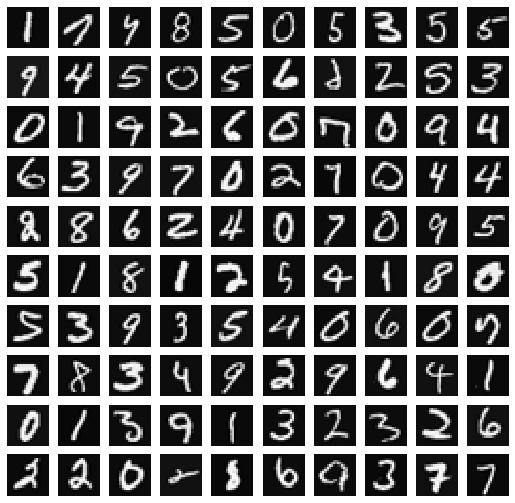

In [6]:
plt.figure(figsize=(9,9))
for i in range(100):
    plt.subplot(10,10,i+1) # 10 rows 10 columns index i+1
    plt.imshow(X[np.random.randint(0,5001)].reshape((20,20)).T, cmap =cm.gray)
    plt.axis('off')
plt.show()

### Sigmoid Function

$\mathrm{sigmoid}(z)=g(z)=\frac{1}{1+e^{-z}}$

In [7]:
def sigmoid(z):
    return 1/(1+np.exp(-z))

In [8]:
sigmoid(0)

0.5

### Sigmoid Gradient

The gradient for the sigmoid function can be computed as

$g'(z)=\frac{d}{dz}g(z) = g(z)(1-g(z))$

In [9]:
def sigmoidGradient(z):
    return sigmoid(z) * (1- sigmoid(z))

In [10]:
#When z = 0, the gradient should be exactly 0.25
sigmoidGradient(0)

0.25

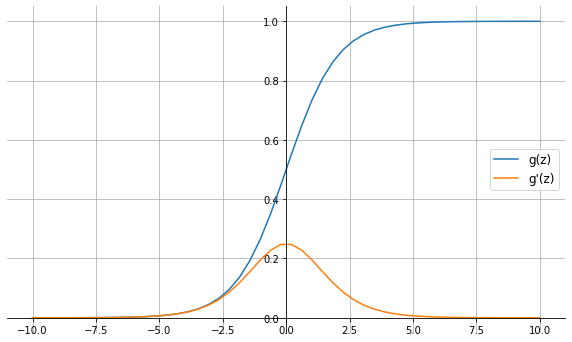

In [11]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(1, 1, 1)
ax.spines['left'].set_position(('data', 0.0))
ax.spines['bottom'].set_position(('data', 0.0))
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
z = np.linspace(-10,10)
plt.plot(z, sigmoid(z), label ="g(z)")
plt.plot(z, sigmoidGradient(z), label = "g\'(z)")
plt.legend(fontsize='large', loc='center right')
plt.grid()
plt.show()

### Random Intitialization

When training neural networks, it is important to randomly initialize the parameters for symmetry breaking. One effective strategy for random initialization is to randomly select values for $\Theta^{(l)}$ uniformly in the range $[-\epsilon_{int},\epsilon_{init}]$. This range of values ensures that the parameters are kept small and makes the learning more efficient. 

One effective strategy for choosing $\epsilon_{init}$ is to base it on the number of units in the network. A good choice of $\epsilon_{init}$ is$\epsilon_{init} = \frac{\sqrt{6}}{\sqrt{L_{in}+L_{out}}},$  where $L_{in} = s_l$ and $L_{out} = s_l+1$ are the number of units in the layers adjacent to $\Theta^{(l)}$.

In [12]:
def randInitializeWeights(L_in,L_out):
    epsilon = 0.12
    W = np.random.rand(L_out, L_in+1) *2*epsilon-epsilon
    return W

### Cost Function

The cost function for neural networks with regularization is given by:
$$
    J(\theta) =
\frac{1}{m}\sum_{i=1}^m
\sum_{k=1}^K 
\left[ -y^{(i)}_k \log((h_{\theta}(x^{(i)})_k)- (1 -y^{(i)}_k) \log(1-(h_{\theta}(x^{(i)}))_k)  \right]
\\ \qquad 
+\frac{\lambda}{2m} \left[\sum_{j=1}^{25} 
\sum_{k=1}^{400} {\left( \Theta_{j,k}^{(1)}\right)^2}+
\sum_{j=1}^{10} 
\sum_{k=1}^{25} {\left( \Theta_{j,k}^{(2)}\right)^2}\right]
$$

In [13]:
def cost(nn_params, input_layer_size, hidden_layer_size,
         num_labels, X, y, lam):
    Theta1 = nn_params[:hidden_layer_size * (input_layer_size + 1)].reshape((hidden_layer_size, input_layer_size + 1))
    Theta2 = nn_params[hidden_layer_size * (input_layer_size + 1):].reshape((num_labels, hidden_layer_size + 1))
    m= X.shape[0]
    X_train = np.insert(X,0,1, axis=1)
    a2 = sigmoid(np.dot(X_train, Theta1.T))
    a2 = np.insert(a2,0,1, axis=1)
    a3 = sigmoid(a2.dot(Theta2.T))
    y_train = np.zeros((m, num_labels))
    y_train[np.arange(X.shape[0]), y - 1] = 1
    J = -(y_train*np.log(a3)) -((1 - y_train)*np.log(1 - a3))
    J = np.sum(J) / m

    reg = np.sum((Theta1[:, 1:]**2)) + np.sum((Theta2[:, 1:]**2))
    J += (reg * lam) / (2 * m)
    return J

In [14]:
input_layer_size = 400
hidden_layer_size = 25
num_labels = 10
nn_params = np.append(Theta1.flatten(), Theta2.flatten())
lam = 1
J= cost(nn_params, input_layer_size, hidden_layer_size,
                         num_labels, X, y, lam)
print(J)  # 0.383770

0.38376985909092365


In [15]:
input_layer_size = 400
hidden_layer_size = 25
num_labels = 10
nn_params = np.hstack((Theta1.ravel(), Theta2.ravel()))
lam = 0
J= cost(nn_params, input_layer_size, hidden_layer_size,
                         num_labels, X, y, lam)
print(J)  # 0.287629

0.2876291651613189


### Backpropagation

Used to calculate:
$\frac{\partial}{\partial\theta_i,_j}J(\theta)$

Which gives us the gradients of the Neural network that can later be used to estimate the optimal parameters

1. Set the input layer's values $(a^{(1)})$ to the $t$-th training example $x^{(t)}$. Perform a feedforward pass computing the activations $(z^{(2)}, a^{(2)}, z^{(3)}, a^{(3)})$  for layers 2 and 3. Note that you need to add a $+1$ term to ensure that the vectors of activations for layers $a^{(1)}$ and  $a^{(2)}$ also include the bias unit
2. For each output unit $k$ in layer 3 (the output layer), set $\delta^{(3)}_k = (a_k^{(3)}-y_k)$ where $y_k\in \{0, 1\}$ indicates whether the current training example belongs to class $k (y_k = 1)$, or if it belongs to a different class $(y_k = 0)$ 
3. For the hidden layer $l = 2$ , set $\delta^{(2)} = (\Theta^{(2)})^T \delta^{(3)}.*g'(z^{(2)})$
4. Accumulate the gradient from this example using the following formula: $\Delta^{(l)} = \Delta^{(l)} + \delta^{(l+1)} (a^{(l)})^T$ . Note that you should skip or remove $\delta_0^{(2)}$. 
5. Obtain the (unregularized) gradient for the neural network cost function by dividing the accumulated gradients by $$\frac{\partial}{\partial\Theta^{(l)}_{ij}} J(\Theta)= D^{(l)}_{ij}= \frac{1}{m}\Delta^{(l)}_{ij}$$
6. Add regularization using
$$
\frac{\partial}{\partial\Theta^{(l)}_{ij}} J(\Theta)= D^{(l)}_{ij}= \frac{1}{m}\Delta^{(l)}_{ij} \text{  for  } j = 0,\\
\frac{\partial}{\partial\Theta^{(l)}_{ij}} J(\Theta)= D^{(l)}_{ij}= \frac{1}{m}\Delta^{(l)}_{ij} +\frac{\lambda}{m}\Theta^{(l)}_{ij} \text{  for  } j \geq 1
$$

In [16]:
def gradient(nn_params, input_layer_size, hidden_layer_size,
             num_labels, X, y, lam):
    Theta1 = nn_params[:hidden_layer_size * (input_layer_size + 1)]
    Theta1 = Theta1.reshape((hidden_layer_size, input_layer_size + 1))
    Theta2 = nn_params[hidden_layer_size * (input_layer_size + 1):]
    Theta2 = Theta2.reshape((num_labels, hidden_layer_size + 1))
    
    m= X.shape[0]
    
    y_train = np.zeros((m, num_labels))
    y_train[np.arange(m), y - 1] = 1
    
    X = np.insert(X,0,1, axis=1)
    #forward propagate
    a2 = sigmoid(X.dot(Theta1.T))
    a2 = np.insert(a2,0,1, axis=1)
    a3 = sigmoid(a2.dot(Theta2.T))
    
    delta_1 = np.zeros((Theta1.shape))
    delta_2 = np.zeros((Theta2.shape))
    
    for i in range(m):
        #forward propagte
        xi= X[i,:] 
        a2i = a2[i,:]
        a3i =a3[i,:]
        #calculate error terms
        d3 = a3i - y_train[i,:]
        d2 = Theta2.T.dot(d3.T) * sigmoidGradient(np.hstack((1,xi.dot(Theta1.T))))
        #accumulate
        delta_1= delta_1 + d2[1:][:,np.newaxis].dot(xi[:,np.newaxis].T)
        delta_2 = delta_2 + d3.T[:,np.newaxis].dot(a2i[:,np.newaxis].T)
        
    delta_1 = 1/m * delta_1
    delta_2 = 1/m*delta_2
    
    #Regularization
    theta1_grad = delta_1 + (lam/m) * np.hstack((np.zeros((Theta1.shape[0],1)),Theta1[:,1:]))
    theta2_grad= delta_2 + (lam/m) * np.hstack((np.zeros((Theta2.shape[0],1)),Theta2[:,1:]))
    
    grad = np.append(theta1_grad.flatten(), theta2_grad.flatten())
    return grad

### Gradient checking

 We can approximate the derivative of our cost function with:
 $$\dfrac{\partial}{\partial\Theta}J(\Theta) \approx \dfrac{J(\Theta + \epsilon) - J(\Theta - \epsilon)}{2\epsilon}$$
 With multiple theta matrices, we can approximate the derivative with respect to $Θj$ as follows:
 
 $$\dfrac{\partial}{\partial\Theta_j}J(\Theta) \approx \dfrac{J(\Theta_1, \dots, \Theta_j + \epsilon, \dots, \Theta_n) - J(\Theta_1, \dots, \Theta_j - \epsilon, \dots, \Theta_n)}{2\epsilon}$$

In [17]:
def checkNNGradients(lam):
    input_layer_size = 3
    hidden_layer_size = 5
    num_labels = 3
    m = 5
    initial_Theta1 = randInitializeWeights(input_layer_size, hidden_layer_size)
    initial_Theta2 = randInitializeWeights(hidden_layer_size, num_labels)
    X = np.random.rand(m, input_layer_size)
    y = np.random.randint(num_labels, size=m)
    nn_params = np.append(initial_Theta1.flatten(), initial_Theta2.flatten())
    grad = gradient(nn_params, input_layer_size, hidden_layer_size, num_labels, X, y, lam)
    num_grad = np.zeros(len(grad))
    e = 1e-4
    for i in range(len(grad)):
        nn_params1 = nn_params.copy()
        nn_params1[i] += e
        cost1 = cost(nn_params1, input_layer_size, hidden_layer_size, num_labels, X, y, lam)
        nn_params2 = nn_params.copy()
        nn_params2[i] -= e
        cost2 = cost(nn_params2, input_layer_size, hidden_layer_size, num_labels, X, y, lam)
        num_grad[i] = (cost1 - cost2) / (2 * e)
    print(grad[:5])
    print(num_grad[:5])
    assert np.linalg.norm(grad - num_grad) / np.linalg.norm(grad + num_grad) < 1e-9

In [18]:
checkNNGradients(0)

[-0.00053582 -0.00030907 -0.00068719 -0.00073878 -0.01380787]
[-0.00053582 -0.00030907 -0.00068719 -0.00073878 -0.01380787]


In [19]:
checkNNGradients(3)

[ 0.00749901  0.01038002 -0.03256777 -0.05679909  0.0049072 ]
[ 0.00749901  0.01038002 -0.03256777 -0.05679909  0.0049072 ]


### Learning parameters

In [20]:
hidden_layer_size = 25
num_labels = 10
initial_Theta1 = randInitializeWeights(input_layer_size, hidden_layer_size)
initial_Theta2 = randInitializeWeights(hidden_layer_size, num_labels)
nn_params = np.hstack((initial_Theta1.ravel(), initial_Theta2.ravel()))
lam = 1

#using scipy-optimize library
params = optimize.minimize(
                        fun=cost, x0=nn_params,
                        args=(input_layer_size, hidden_layer_size, num_labels, X, y, lam),
                        method='CG', jac=gradient, options={"maxiter": 50}
                        )

In [21]:
Theta1 = params.x[:hidden_layer_size * (input_layer_size + 1)].reshape((hidden_layer_size, input_layer_size + 1))
Theta2 = params.x[hidden_layer_size * (input_layer_size + 1):].reshape((num_labels, hidden_layer_size + 1))

In [22]:
print(Theta1.shape, Theta2.shape)

(25, 401) (10, 26)


### Visualizing the hidden layer

One way to understand what your neural network is learning is to visualize what the representations captured by the hidden units. Informally, given a particular hidden unit, one way to visualize what it computes is to find an input x that will cause it to activate (that is, to have an activation value $(a^{(l)}_i)$ close to 1). For the neural network you trained, notice that the $i^{th}$ row of $\Theta^{(1)}$ is a 401-dimensional vector that represents the parameter for the $i^{th}$ hidden unit. If we discard the bias term, we get a 400 dimensional vector that represents the weights from each input pixel to the hidden unit. 
    Thus, one way to visualize the 'representation' captured by the hidden unit is to reshape this 400 dimensional vector into a 20 x 20 image and display it.* 

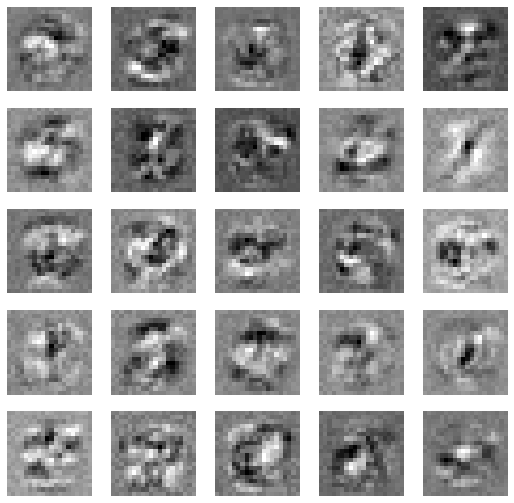

In [23]:
plt.figure(figsize=(9,9))
for i in range(25):
    plt.subplot(5,5, i+1)
    plt.imshow(Theta1[i, 1:].reshape((20,20)).T, cmap=cm.gray)
    plt.axis('off')
plt.show()

In [24]:
def predict(Theta1,Theta2,X):
    #Hidden layer
    a1 = np.insert(X,0,1, axis=1)
    a2 = sigmoid(a1.dot(Theta1.T))
    
    #output layer
    a2 = np.insert(a2,0,1, axis=1)
    a3 = sigmoid(a2.dot(Theta2.T))
    
    predictions = np.argmax(a3, axis=1) +1
    return predictions

In [25]:
accuracy = np.mean(predict(Theta1,Theta2,X)==y)
print(f'Accuracy = {np.round(accuracy*100,2)}%')

Accuracy = 95.86%


## Testing the network with custom images

In [26]:
from PIL import Image,ImageFilter #image processing library

In [27]:
#A helper function to display the images
def display(img, c=None):
    %matplotlib inline
    plt.imshow(np.asarray(img), cmap=c)
    plt.show()

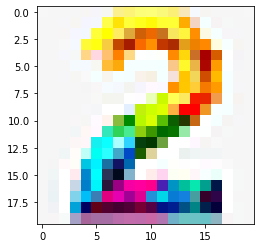

In [28]:
#show the image
image = Image.open('two.jpg').resize((20, 20), Image.ANTIALIAS).filter(ImageFilter.SHARPEN)
display(image)

In [29]:
#convert to gray
gray_image = image.convert('L')

In [30]:
vect = np.asarray(gray_image).ravel()
vect.shape

(400,)

In [31]:
# normalize pixels to 0 and 1. 0 is pure white, 1 is pure black.
vector = [(255 - x) * 1.0 / 255.0 for x in vect]
vector = np.array(vector)

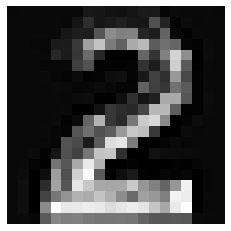

In [32]:
plt.imshow(vector.reshape((20,20)), cmap=cm.gray)
plt.axis('off')
plt.show()

In [33]:
p = predict(Theta1, Theta2, vector[:,np.newaxis].T)
print(f'The nework predicts digit {p[0]}')

The nework predicts digit 2
